In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ruptures as rpt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error

In [3]:
# Wczytanie danych
data = pd.read_csv('ai4i2020.csv')
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [4]:
# Usunięcie danych występujących po ostatniej awarii
last_failure = data[data['Machine failure'] == 1].index.max()
data = data[:last_failure+1]

In [5]:
# One-hot encoding kolumny 'Type'
data = pd.get_dummies(data, columns=['Type'], dtype=int)

In [6]:
# Dodanie time_cycle i failure_number
data['time_cycle'] = 1
data['failure_number'] = 0
current_cycle = 1
failure_number = 1
for idx in data.index:
    data.at[idx, 'time_cycle'] = current_cycle
    data.at[idx, 'failure_number'] = failure_number
    current_cycle += 1
    if data.at[idx, 'Machine failure'] == 1:
        failure_number += 1
        current_cycle = 1

In [7]:
# Usuwanie zbędnych kolumn
data.drop(['Product ID', 'UDI','Machine failure', 'TWF','HDF','PWF','OSF','RNF'], axis=1, inplace=True)

In [8]:
# Dodanie dodatkowych cech
data['Torque_Rotational_speed'] = data['Torque [Nm]'] * data['Rotational speed [rpm]']
data['Temperature_difference'] = data['Process temperature [K]'] - data['Air temperature [K]']
data['tool_wear_torque'] = data['Tool wear [min]'] * data['Torque [Nm]']
data['tool_wear_torque>=11000'] = (data['tool_wear_torque'] >= 11000).astype(int)
data['tool_wear_torque>=12000'] = (data['tool_wear_torque'] >= 12000).astype(int)
data['tool_wear_torque>=13000'] = (data['tool_wear_torque'] >= 13000).astype(int)

In [9]:
# Usunięcie awarii, które nastąpiły zbyt szybko
data = data.groupby('failure_number').filter(lambda x: len(x) >= 15)
data.reset_index(drop=True, inplace=True)
data['failure_number'] = pd.factorize(data['failure_number'])[0] + 1

In [10]:
# Podzielenie danych na treningowe i testowe
failure_number_max = data['failure_number'].max()
dataTrain = data[data['failure_number']<=failure_number_max-5].copy()
dataTest = data[data['failure_number']>failure_number_max-5].copy()
dataTest['failure_number'] = dataTest['failure_number']-dataTrain['failure_number'].max()

In [11]:
# Funkcja wykrywająca punkty degradacji w danych
def detect_change_point(data):
    failures = data['failure_number'].unique()
    change_point_indices = []

    for failure in failures:
        # Filtracja danych dla konkretnej awari
        failure_data = data[data['failure_number'] == failure]
        # Wybór istotnych cech do analizy
        failure_features = failure_data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
                                         'Temperature_difference','Torque_Rotational_speed','tool_wear_torque']].values

        # Wykrycie punktu degradacji
        algo = rpt.Pelt(model="rbf").fit(failure_features)
        result = algo.predict(pen=2)

         # Wybranie ostatniego wykrytego punktu zmiany jako punkt degradacji
        if len(result) > 1:
            change_point_index = failure_data.index[result[-2] - 1]
            change_point_indices.append(change_point_index)
        else:
            change_point_indices.append(failure_data.index[-5])  # Jeśli nie wykryto punktu, wybieramy 5 próbkę od końca
    return change_point_indices
# Wykrycie punktów degradacji w zestawie treningowym i oznaczenie ich jako anomalie
change_point_indices = detect_change_point(dataTrain)
dataTrain['anomaly'] = 0
dataTrain.loc[change_point_indices, 'anomaly'] = 1

In [12]:
#Dodanie kolumny RUL
def add_rul_column(data, anomaly_indices):
    MAX_LIFE = 20
    data['RUL'] = 0.0
    for failure in data['failure_number'].unique():
        # Filtracja danych dla konkretnej awarii
        failure_data = data[data['failure_number'] == failure]
        # Pobranie indeksu anomalii dla bieżącej awarii
        anomaly_index = anomaly_indices[failure - 1]
        anomaly_pos = failure_data.index.get_loc(anomaly_index)

        # Przypisanie RUL przed anomalią
        data.loc[failure_data.index[:anomaly_pos], 'RUL'] = MAX_LIFE
        steps_after_anomaly = len(failure_data) - anomaly_pos
        # Przypisanie RUL po anomalii
        data.loc[failure_data.index[anomaly_pos:], 'RUL'] = np.linspace(MAX_LIFE, 0, steps_after_anomaly)

    return data

dataTrain = add_rul_column(dataTrain, change_point_indices)
#Wyznaczenie RUL dla danych testowych
change_point_indices = detect_change_point(dataTest)
dataTest['anomaly'] = 0
dataTest.loc[change_point_indices, 'anomaly'] = 1
dataTest = add_rul_column(dataTest, change_point_indices)

In [13]:
# Zapisanie kopii danych przed usunięciem zbędnych kolumn i normalizacją
dataTrain_copy = dataTrain.copy()
dataTest_copy = dataTest.copy()

In [14]:
# Normalizacja wybranych cech
features = ['time_cycle','Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                     'Torque [Nm]', 'Tool wear [min]','Temperature_difference','Torque_Rotational_speed','tool_wear_torque']
scaler = StandardScaler()
dataTrain[features] = scaler.fit_transform(dataTrain[features])
dataTest[features] = scaler.transform(dataTest[features])

In [15]:
# Usunięcie zbędnych kolumn
dataTrain.drop(['failure_number','anomaly'], axis=1, inplace=True)
dataTest.drop(['failure_number','anomaly'], axis=1, inplace=True)

In [16]:
sequence_length = 20
# Funkcja tworząca sekwencje dla LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length + 1):
        X.append(data.iloc[i:i+seq_length].drop('RUL', axis=1).values)
        y.append(data.iloc[i + seq_length-1]['RUL'])
    return np.array(X), np.array(y)
dataTest2 = dataTest.copy().reset_index(drop=True)
# Dodanie ostatnich wierszy z danych treningowych, aby utworzyć pełne sekwencje
if sequence_length > 1:
    dataTest2 = pd.concat([dataTrain.iloc[-sequence_length+1:], dataTest], ignore_index=True)
# Tworzenie sekwencji dla zbioru treningowego i testowego
X_train, Y_train = create_sequences(dataTrain, sequence_length)
X_test, y_test = create_sequences(dataTest2, sequence_length)

In [17]:
# Definicja modelu LSTM
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse',metrics=['mse'])

In [18]:
# Uczenie modelu LSTM
model.fit(
    X_train, Y_train,
    epochs=100,
    verbose=1
)

Epoch 1/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 118.6391 - mse: 118.6391
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 34.7477 - mse: 34.7477
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 24.2532 - mse: 24.2532
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 20.4987 - mse: 20.4987
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 20.3755 - mse: 20.3755
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 20.1922 - mse: 20.1922
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 19.8498 - mse: 19.8498
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 18.5477 - mse: 18.5477
Epoch 9/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 19.0298 - mse: 19.0298
Epoch 10/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 16.8808 - mse: 16.8808
Epoch 11/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 16.9063 - mse: 16.9063
Epoch 12/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss:

In [19]:
# Predykcja danych testowych
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse:.2f}")
def plot_rul_comparison(data, failure_number, predictions):
    # Filtracja danych dla określonej awarii
    failure_data = data[data['failure_number'] == failure_number]
    idx = data[data['failure_number'] == failure_number].index.min() - data[data['failure_number'] == 1].index.min()
    # Pobranie rzeczywistych RUL
    actual_rul = failure_data['RUL'].values
    predicted_rul = predictions[idx : idx + len(actual_rul)]
    plt.figure(figsize=(10, 6))
    plt.plot(failure_data['time_cycle'], actual_rul, label='Actual RUL', linestyle='--', marker='o')
    plt.plot(failure_data['time_cycle'], predicted_rul, label=f'Predicted RUL', marker='x')
    plt.title(f'Porównanie RUL dla awarii {failure_number}')
    plt.xlabel('Czas w cyklach')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True)
    plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
MSE: 25.53


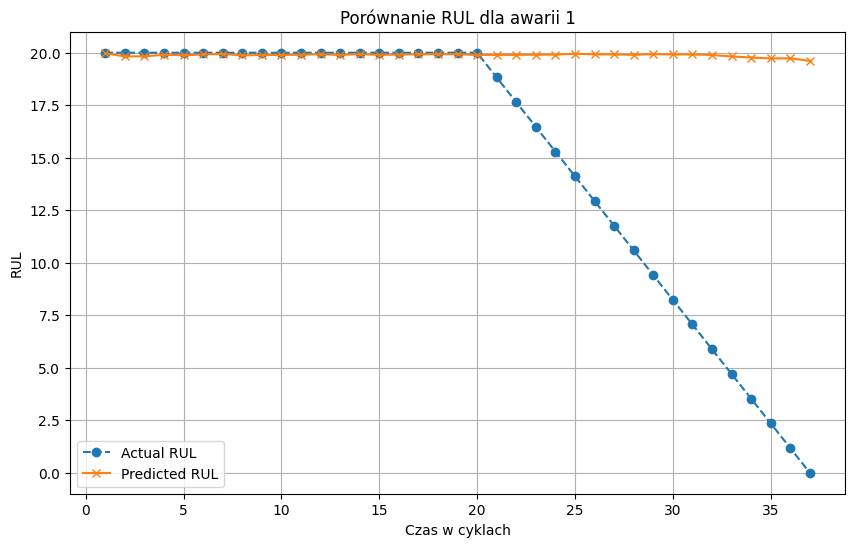

In [20]:
failure_number = 1
plot_rul_comparison(dataTest_copy, failure_number, predictions)

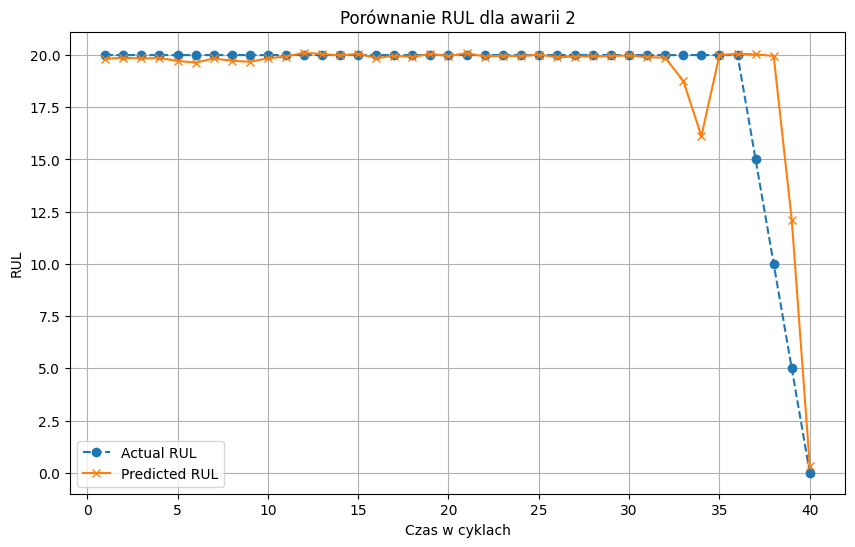

In [21]:
failure_number = 2
plot_rul_comparison(dataTest_copy, failure_number, predictions)

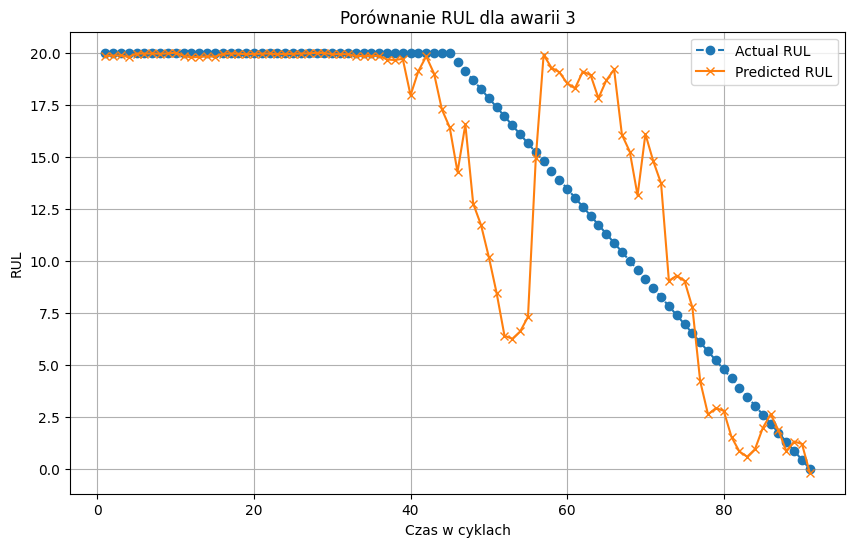

In [22]:
failure_number = 3
plot_rul_comparison(dataTest_copy, failure_number, predictions)

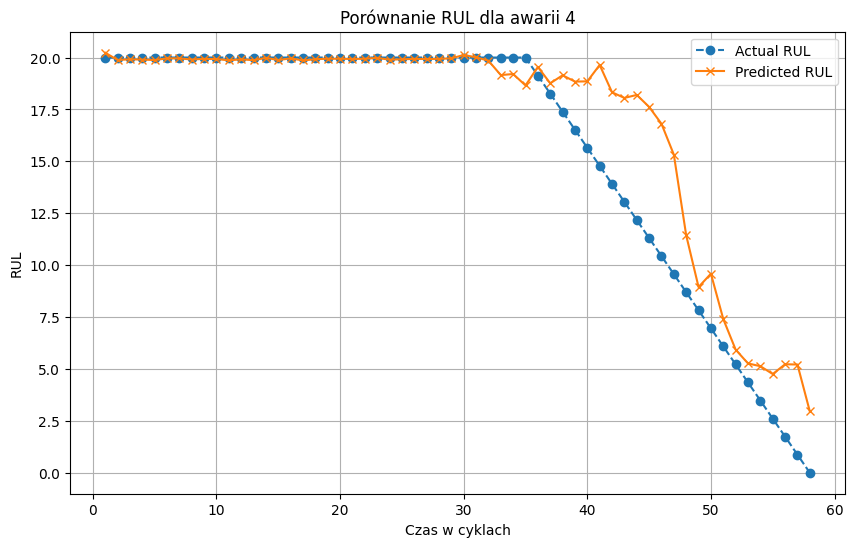

In [23]:
failure_number = 4
plot_rul_comparison(dataTest_copy, failure_number, predictions)

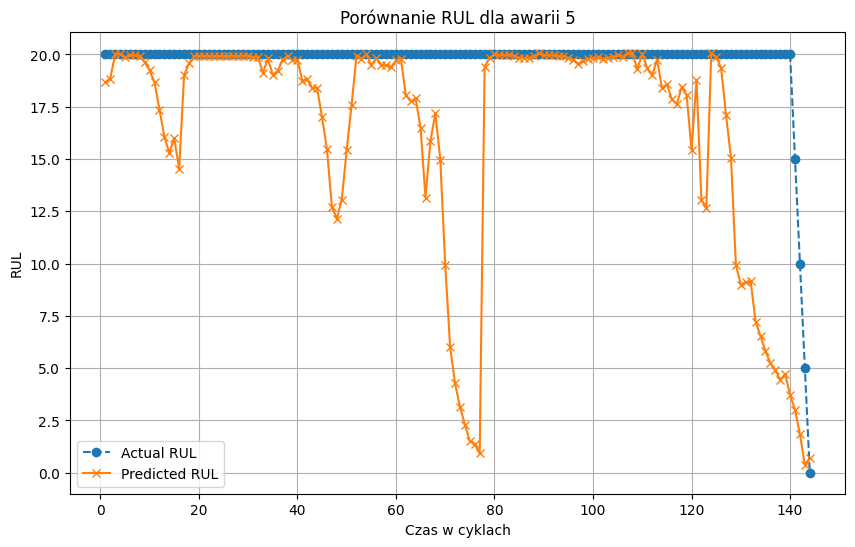

In [24]:
failure_number = 5
plot_rul_comparison(dataTest_copy, failure_number, predictions)